# Imports

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv2D, Flatten, Dense, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Setup

In [2]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect  actions = np.array(['Familja', 'Missier', 'Bieb'])
#actions = np.array(['Account','Flus','Missier', 'Dar', 'Passport', 'Pin'])
#actions = np.array(['Account','Dar','Flus', 'Missier', 'Passport'])
actions = np.array(['Dar', 'Missier', 'Passport'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

label_map = {label:num for num, label in enumerate(actions)}

label_map # When this is added accuracy skyrockets IMP

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape
np.array(labels).shape
X = np.array(sequences)
X.shape
y = to_categorical(labels).astype(int)

# LSTM Model 1
LSTM layers = 3;
Sizes = 64, 64, 128;
activation function = Relu;

Epoch 1/200
2/2 [==============================] - 8s 1s/step - loss: 1.2491 - categorical_accuracy: 0.4211 - val_loss: 8.6964 - val_categorical_accuracy: 0.3333
Epoch 2/200
2/2 [==============================] - 0s 387ms/step - loss: 31.3992 - categorical_accuracy: 0.4035 - val_loss: 1.0279 - val_categorical_accuracy: 0.4000
Epoch 3/200
2/2 [==============================] - 0s 308ms/step - loss: 1.0314 - categorical_accuracy: 0.4211 - val_loss: 2.7898 - val_categorical_accuracy: 0.3333
Epoch 4/200
2/2 [==============================] - 2s 1s/step - loss: 1.7990 - categorical_accuracy: 0.3860 - val_loss: 1.1800 - val_categorical_accuracy: 0.3333
Epoch 5/200
2/2 [==============================] - 0s 302ms/step - loss: 1.1709 - categorical_accuracy: 0.2807 - val_loss: 1.3761 - val_categorical_accuracy: 0.0000e+00
Epoch 6/200
2/2 [==============================] - 0s 303ms/step - loss: 1.3859 - categorical_accuracy: 0.2105 - val_loss: 1.1043 - val_categorical_accuracy: 0.5333
Epoch 7/200

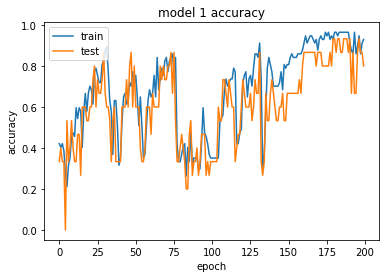

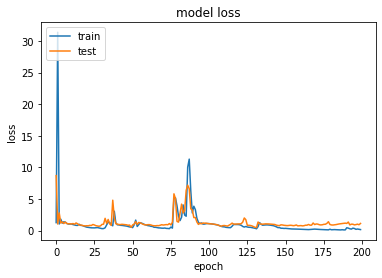

              precision    recall  f1-score   support

         Dar       1.00      0.33      0.50         6
     Missier       0.64      1.00      0.78         7
    Passport       1.00      1.00      1.00         5

    accuracy                           0.78        18
   macro avg       0.88      0.78      0.76        18
weighted avg       0.86      0.78      0.75        18

Confusion Matrix
[[[12  0]
  [ 4  2]]

 [[ 7  4]
  [ 0  7]]

 [[13  0]
  [ 0  5]]]
Accuracy
0.7777777777777778


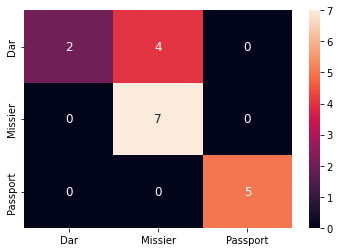

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, callbacks=[tb_callback])

model.summary()


# list all data in history
print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

res = model.predict(X_test)
actions[np.argmax(res[4])]
actions[np.argmax(y_test[4])]

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
report = multilabel_confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)

print(classification_report(ytrue, yhat,target_names=actions))

print("Confusion Matrix")
print(report)
print("Accuracy")
print(accuracy)



cm_labels = np.unique(ytrue)
cm_array = confusion_matrix(ytrue, yhat)
cm_array_df = pd.DataFrame(cm_array, index=actions, columns=actions)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12})

model.save('model1.h5')

# LSTM Model 2
LSTM layers = 4;
Sizes = 128, 256, 128;
activation function = Softmax;

Epoch 1/200
2/2 [==============================] - 9s 2s/step - loss: 4.7973 - categorical_accuracy: 0.3860 - val_loss: 51.3384 - val_categorical_accuracy: 0.4000
Epoch 2/200
2/2 [==============================] - 2s 1s/step - loss: 96.1745 - categorical_accuracy: 0.4211 - val_loss: 249.7643 - val_categorical_accuracy: 0.2000
Epoch 3/200
2/2 [==============================] - 3s 2s/step - loss: 193.7236 - categorical_accuracy: 0.3509 - val_loss: 81.9475 - val_categorical_accuracy: 0.4000
Epoch 4/200
2/2 [==============================] - 2s 1s/step - loss: 365.3124 - categorical_accuracy: 0.3509 - val_loss: 1097.2722 - val_categorical_accuracy: 0.3333
Epoch 5/200
2/2 [==============================] - 2s 1s/step - loss: 982.5940 - categorical_accuracy: 0.2982 - val_loss: 1057.8362 - val_categorical_accuracy: 0.4000
Epoch 6/200
2/2 [==============================] - 2s 1s/step - loss: 1676.8058 - categorical_accuracy: 0.3509 - val_loss: 3602.5583 - val_categorical_accuracy: 0.4000
Epoch

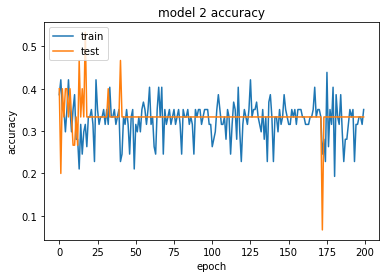

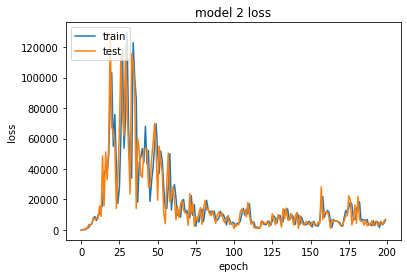

C:\Users\keane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\keane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\keane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

              precision    recall  f1-score   support

         Dar       0.00      0.00      0.00         6
     Missier       0.00      0.00      0.00         7
    Passport       0.28      1.00      0.43         5

    accuracy                           0.28        18
   macro avg       0.09      0.33      0.14        18
weighted avg       0.08      0.28      0.12        18

Confusion Matrix
[[[12  0]
  [ 6  0]]

 [[11  0]
  [ 7  0]]

 [[ 0 13]
  [ 0  5]]]
Accuracy
0.2777777777777778


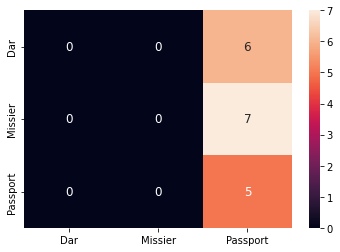

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = Sequential()
model.add(LSTM(500, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(500, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, callbacks=[tb_callback])

model.summary()


# list all data in history
print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

res = model.predict(X_test)
actions[np.argmax(res[4])]
actions[np.argmax(y_test[4])]

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
report = multilabel_confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)

print(classification_report(ytrue, yhat,target_names=actions))

print("Confusion Matrix")
print(report)
print("Accuracy")
print(accuracy)



cm_labels = np.unique(ytrue)
cm_array = confusion_matrix(ytrue, yhat)
cm_array_df = pd.DataFrame(cm_array, index=actions, columns=actions)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12})

model.save('model2.h5')

# LSTM Model 3
LSTM layers = 3;
Sizes = 64, 64, 64;
activation function = tanh;

Epoch 1/100
2/2 [==============================] - 12s 2s/step - loss: 1.1241 - categorical_accuracy: 0.2807 - val_loss: 1.0849 - val_categorical_accuracy: 0.3333
Epoch 2/100
2/2 [==============================] - 1s 475ms/step - loss: 1.0881 - categorical_accuracy: 0.3509 - val_loss: 1.0930 - val_categorical_accuracy: 0.3333
Epoch 3/100
2/2 [==============================] - 0s 265ms/step - loss: 1.1054 - categorical_accuracy: 0.3509 - val_loss: 1.0670 - val_categorical_accuracy: 0.3333
Epoch 4/100
2/2 [==============================] - 0s 180ms/step - loss: 1.0607 - categorical_accuracy: 0.3333 - val_loss: 1.0392 - val_categorical_accuracy: 0.3333
Epoch 5/100
2/2 [==============================] - 0s 183ms/step - loss: 1.0220 - categorical_accuracy: 0.3860 - val_loss: 0.9820 - val_categorical_accuracy: 0.7333
Epoch 6/100
2/2 [==============================] - 0s 193ms/step - loss: 0.9659 - categorical_accuracy: 0.5088 - val_loss: 0.9510 - val_categorical_accuracy: 0.6667
Epoch 7/100


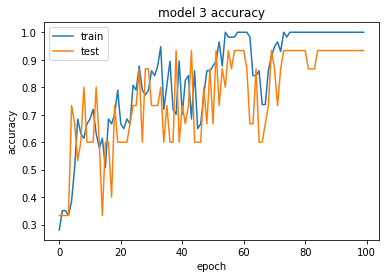

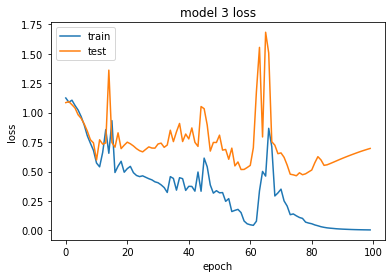

              precision    recall  f1-score   support

         Dar       0.86      1.00      0.92         6
     Missier       1.00      0.86      0.92         7
    Passport       1.00      1.00      1.00         5

    accuracy                           0.94        18
   macro avg       0.95      0.95      0.95        18
weighted avg       0.95      0.94      0.94        18

Confusion Matrix
[[[11  1]
  [ 0  6]]

 [[11  0]
  [ 1  6]]

 [[13  0]
  [ 0  5]]]
Accuracy
0.9444444444444444


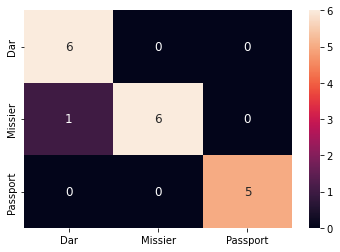

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[tb_callback])

model.summary()


# list all data in history
print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

res = model.predict(X_test)
actions[np.argmax(res[4])]
actions[np.argmax(y_test[4])]

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
report = multilabel_confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)

print(classification_report(ytrue, yhat,target_names=actions))

print("Confusion Matrix")
print(report)
print("Accuracy")
print(accuracy)



cm_labels = np.unique(ytrue)
cm_array = confusion_matrix(ytrue, yhat)
cm_array_df = pd.DataFrame(cm_array, index=actions, columns=actions)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12})

model.save('model3.h5')


# Dataset 2 Setup on best Model

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect  actions = np.array(['Familja', 'Missier', 'Bieb'])
#actions = np.array(['Account','Flus','Missier', 'Dar', 'Passport', 'Pin'])
#actions = np.array(['Account','Dar','Flus', 'Missier', 'Passport'])
actions = np.array(['Dar', 'Missier', 'Passport'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

label_map = {label:num for num, label in enumerate(actions)}

label_map # When this is added accuracy skyrockets IMP

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape
np.array(labels).shape
X = np.array(sequences)
X.shape
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, callbacks=[tb_callback])

model.summary()


# list all data in history
print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

res = model.predict(X_test)
actions[np.argmax(res[4])]
actions[np.argmax(y_test[4])]

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
report = multilabel_confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)

print(classification_report(ytrue, yhat,target_names=actions))

print("Confusion Matrix")
print(report)
print("Accuracy")
print(accuracy)



cm_labels = np.unique(ytrue)
cm_array = confusion_matrix(ytrue, yhat)
cm_array_df = pd.DataFrame(cm_array, index=actions, columns=actions)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12})

model.save('dataset2.h5')

# Dataset 3 Setup on best Model

In [5]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('largedata') 

# Actions that we try to detect  actions = np.array(['Familja', 'Missier', 'Bieb'])
actions = np.array(['Account','Dar','Flus','Missier','Passport', 'Pin'])
#actions = np.array(['Account','Dar','Flus', 'Missier', 'Passport'])
#actions = np.array(['Dar', 'Missier', 'Passport'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

label_map = {label:num for num, label in enumerate(actions)}

label_map # When this is added accuracy skyrockets IMP

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape
np.array(labels).shape
X = np.array(sequences)
X.shape
y = to_categorical(labels).astype(int)

Epoch 1/130
4/4 [==============================] - 12s 723ms/step - loss: 1.7981 - categorical_accuracy: 0.1826 - val_loss: 1.8126 - val_categorical_accuracy: 0.1034
Epoch 2/130
4/4 [==============================] - 0s 118ms/step - loss: 1.7864 - categorical_accuracy: 0.2870 - val_loss: 1.8340 - val_categorical_accuracy: 0.1034
Epoch 3/130
4/4 [==============================] - 0s 113ms/step - loss: 1.7822 - categorical_accuracy: 0.1913 - val_loss: 1.8280 - val_categorical_accuracy: 0.1034
Epoch 4/130
4/4 [==============================] - 0s 107ms/step - loss: 1.7760 - categorical_accuracy: 0.2609 - val_loss: 1.8321 - val_categorical_accuracy: 0.2069
Epoch 5/130
4/4 [==============================] - 0s 118ms/step - loss: 1.7466 - categorical_accuracy: 0.3130 - val_loss: 1.7980 - val_categorical_accuracy: 0.1724
Epoch 6/130
4/4 [==============================] - 0s 122ms/step - loss: 1.7082 - categorical_accuracy: 0.3478 - val_loss: 1.7531 - val_categorical_accuracy: 0.1724
Epoch 7/1

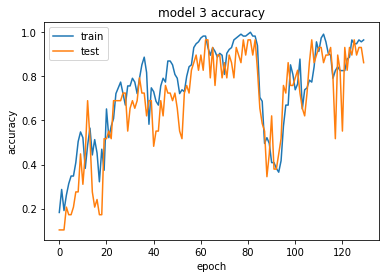

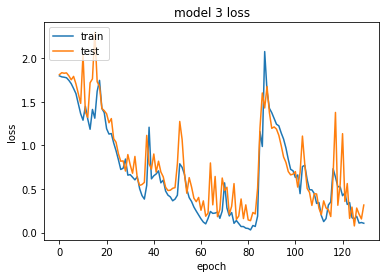

              precision    recall  f1-score   support

     Account       0.83      1.00      0.91         5
         Dar       0.38      1.00      0.55         3
        Flus       1.00      1.00      1.00         7
     Missier       1.00      0.11      0.20         9
    Passport       1.00      1.00      1.00         6
         Pin       0.62      0.83      0.71         6

    accuracy                           0.75        36
   macro avg       0.81      0.82      0.73        36
weighted avg       0.86      0.75      0.70        36

Confusion Matrix
[[[30  1]
  [ 0  5]]

 [[28  5]
  [ 0  3]]

 [[29  0]
  [ 0  7]]

 [[27  0]
  [ 8  1]]

 [[30  0]
  [ 0  6]]

 [[27  3]
  [ 1  5]]]
Accuracy
0.75


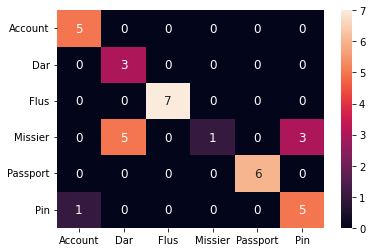

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
y_test.shape

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=130, callbacks=[tb_callback])

model.summary()


# list all data in history
print(history.history.keys())

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

res = model.predict(X_test)
actions[np.argmax(res[4])]
actions[np.argmax(y_test[4])]

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
report = multilabel_confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)

print(classification_report(ytrue, yhat,target_names=actions))

print("Confusion Matrix")
print(report)
print("Accuracy")
print(accuracy)



cm_labels = np.unique(ytrue)
cm_array = confusion_matrix(ytrue, yhat)
cm_array_df = pd.DataFrame(cm_array, index=actions, columns=actions)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12})

model.save('dataset3.h5')